In [1]:
import numpy as np
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
import time
from tqdm import tqdm
from VolcGases.functions import solve_gases

import warnings
warnings.filterwarnings('ignore')

In [2]:
# The total H and C mass fractions
mCO2tot=1000e-6
mH2Otot=1000e-6

# set total pressure and temperature
T = 1473 # kelvin
P = 1000 # bar
x = 0.01550152865954013
FMQ = 0

# set the Oxygen fugacity to FMQ
A = 25738
B = 9
C = 0.092
log_FMQ = (-A/T+B+C*(P-1)/T)
f_O2 = 10**(log_FMQ+FMQ)
# set to FMQ

start = time.time()
P_H2O,P_H2,P_CO2,P_CO,P_CH4,alphaG,x_CO2,x_H2O = solve_gases(T,P,f_O2,mCO2tot,mH2Otot)
print(time.time()-start)
print('H2O mix rat =','%.2e'%(P_H2O/P))
print('H2 mix rat  =','%.2e'%(P_H2/P))
print('CO2 mix rat =','%.2e'%(P_CO2/P))
print('CO mix rat  =','%.2e'%(P_CO/P))
print('CH4 mix rat =','%.2e'%(P_CH4/P))
print('alphaG =','%.2e'%alphaG)

0.008189201354980469
H2O mix rat = 1.68e-03
H2 mix rat  = 3.52e-05
CO2 mix rat = 9.49e-01
CO mix rat  = 4.89e-02
CH4 mix rat = 8.13e-12
alphaG = 4.53e-04


In [3]:
# make distributions
np.random.seed(1)
n = 10000

inputs = range(0,n)

# change these too
mCO2toto_r=[-5,-2] # Approximate range in Earth MORB Wallace and Anderson 1999, Marty et al. 2012, Wallace 2005
mH2Ototo_r=[-5,-1] # Dissolved submarine range for Earth Wallace and Anderson 1999
                   # Figure 10
mCO2totc_r=[-5,-2] # Approximate range in Earth MORB Wallance and Anderson 1999, Marty et al. 2012, Wallace 2005
mH2Ototc_r=[-5,-1] # Dissolved subaerial range for Earth Wallace and Anderson 1999
                   # Figure 11
mCO2toto = 10**np.random.uniform(low=mCO2toto_r[0], high=mCO2toto_r[1], size=n)
mH2Ototo = 10**np.random.uniform(low=mH2Ototo_r[0], high=mH2Ototo_r[1], size=n)
mCO2totc = 10**np.random.uniform(low=mCO2totc_r[0], high=mCO2totc_r[1], size=n)
mH2Ototc = 10**np.random.uniform(low=mH2Ototc_r[0], high=mH2Ototc_r[1], size=n)
#mCO2totc = mCO2toto
#mH2Ototc = 10**mH2Ototo

# Choose range of T and P and fO2
Tc_r = [873,1973] # coldest magmas to Komatiite magmas ( ,Huppert et al. 1984)
Pc_r = [1e-3,100] # Roughly subaerial degassing pressure range in the solar system
To_r = [873,1973] # coldest magmas to Komatiite magmas ( ,Huppert et al. 1984)
Po_r = [100,1000] # Magma solubility doesn't allow for siginifcant degassing at higher pressure
f_O2_r = [-4,5] # Range of O2 fugacities observed on Earth (Stamper et al. 2014)
                # White dwarfs pollution are evidence that similar O2 fuagacities on exoplanets (Doyle et al. 2019)
                # encompasses O2 fugacity of martian meteorites (Catling and Kasting 2017)
X_r = [0,1] # 0% to 100% subaerial volcanism

LG = 1
Delta_f_O2 = np.random.uniform(low=f_O2_r[0], high=f_O2_r[1], size=n)
Tc = np.random.uniform(low=Tc_r[0], high=Tc_r[1], size=n)
Pc = np.random.uniform(low=Pc_r[0], high=Pc_r[1], size=n)
To = np.random.uniform(low=To_r[0], high=To_r[1], size=n)
Po = np.random.uniform(low=Po_r[0], high=Po_r[1], size=n)
X = np.random.uniform(low=X_r[0], high=X_r[1], size=n)
if LG==1:
    # log stuff
    Pc_r = [np.log10(Pc_r[0]),np.log10(Pc_r[1])]
    Pc = 10**np.random.uniform(low=Pc_r[0], high=Pc_r[1], size=n)


# little bit more to get f_O2
A = 25738
B = 9
C = 0.092
log_fO2_c = (-A/Tc+B+C*(Pc-1)/Tc)+Delta_f_O2
f_O2_c = 10**(log_fO2_c)

log_fO2_o = (-A/To+B+C*(Po-1)/To)+Delta_f_O2
f_O2_o = 10**(log_fO2_o)

In [4]:
# ocean world 
def flux_ratios_iter(T,P,f_O2,mCO2tot,mH2Otot):
    P_H2O,P_H2,P_CO2,P_CO,P_CH4,alphaG,x_CO2,x_H2O = solve_gases(T,P,f_O2,mCO2tot,mH2Otot)
    #CO_CO2 = P_CO/P_CO2
    CO_CO2 = P_CO2/P_CO
    CO_CH4 = P_CH4/P_CO
    
#     CO2 = 1000*alphaG*x*(1/(1-alphaG))*P_CO2/P
#     CH4 = 1000*alphaG*x*(1/(1-alphaG))*P_CH4/P
#     CO = 1000*alphaG*x*(1/(1-alphaG))*P_CO/P
    
    CO2 = 1000*alphaG*x*P_CO2/P
    CH4 = 1000*alphaG*x*P_CH4/P
    CO = 1000*alphaG*x*P_CO/P
    

    return (CO_CO2,CO_CH4,CO,CH4,CO2)

num_cores = multiprocessing.cpu_count()
start = time.time()
resultso = Parallel(n_jobs=num_cores)(delayed(flux_ratios_iter)\
            (To[i],Po[i],f_O2_o[i],mCO2toto[i],mH2Ototo[i]) for i in tqdm(inputs))
end = time.time()
print(end-start)

resultso = np.array(resultso)

100%|██████████| 10000/10000 [00:07<00:00, 1266.70it/s]


8.526023864746094


In [5]:
# mix land-ocean world
def flux_ratios_iter(To,Tc,Po,Pc,f_O2_o,f_O2_c,mCO2toto,mH2Ototo,mCO2totc,mH2Ototc,X):
    P_H2O_o,P_H2_o,P_CO2_o,P_CO_o,P_CH4_o,alphaG_o,x_CO2_o,x_H2O_o = solve_gases(To,Po,f_O2_o,mCO2toto,mH2Ototo)    
    P_H2O_c,P_H2_c,P_CO2_c,P_CO_c,P_CH4_c,alphaG_c,x_CO2_c,x_H2O_c = solve_gases(Tc,Pc,f_O2_c,mCO2totc,mH2Ototc)
    
    
    # this gives mol gas/kg magma
#     CO2_b = X*(1000*alphaG_c*x*(1/(1-alphaG_c))*P_CO2_c/Pc)+(1-X)*(1000*alphaG_o*x*(1/(1-alphaG_o))*P_CO2_o/Po)
#     CO_b = X*(1000*alphaG_c*x*(1/(1-alphaG_c))*P_CO_c/Pc)+(1-X)*(1000*alphaG_o*x*(1/(1-alphaG_o))*P_CO_o/Po)
#     CH4_b = X*(1000*alphaG_c*x*(1/(1-alphaG_c))*P_CH4_c/Pc)+(1-X)*(1000*alphaG_o*x*(1/(1-alphaG_o))*P_CH4_o/Po)
    
    CO2_b = X*(1000*alphaG_c*x*P_CO2_c/Pc)+(1-X)*(1000*alphaG_o*x*P_CO2_o/Po)
    CO_b = X*(1000*alphaG_c*x*P_CO_c/Pc)+(1-X)*(1000*alphaG_o*x*P_CO_o/Po)
    CH4_b = X*(1000*alphaG_c*x*P_CH4_c/Pc)+(1-X)*(1000*alphaG_o*x*P_CH4_o/Po)
    
    # this gives mol gas/kg magma
    P_CO2_b = X*(P_CO2_c/Pc)+(1-X)*(P_CO2_o/Po)
    P_CO_b = X*(P_CO_c/Pc)+(1-X)*(P_CO_o/Po)
    P_CH4_b = X*(P_CH4_c/Pc)+(1-X)*(P_CH4_o/Po)
 
    
    CO_CO2 = P_CO2_b/P_CO_b
    CO_CH4 = P_CH4_b/P_CO_b
    
#     CO_CO2 = X*(P_CO_c/P_CO2_c)+(1-X)*(P_CO_o/P_CO2_o)
#     CO_CH4 = X*(P_CO_c/P_CH4_c)+(1-X)*(P_CO_o/P_CH4_o)

    return (CO_CO2,CO_CH4,CO_b,CH4_b,CO2_b)

num_cores = multiprocessing.cpu_count()
start = time.time()
resultsb = Parallel(n_jobs=num_cores)(delayed(flux_ratios_iter)\
            (To[i],Tc[i],Po[i],Pc[i],f_O2_o[i],f_O2_c[i],mCO2toto[i],mH2Ototo[i],mCO2totc[i],mH2Ototc[i],X[i]) for i in tqdm(inputs))
end = time.time()
print(end-start)

resultsb = np.array(resultsb)

100%|██████████| 10000/10000 [00:12<00:00, 789.95it/s]


13.223788976669312


In [6]:
#np.savetxt('ocean_world.txt',resultso)
#resultso = np.loadtxt('ocean_world.txt')

#np.savetxt('ocean_continent_combo.txt',resultsb)
#resultsb = np.loadtxt('ocean_continent_combo.txt')

fraction of Ocean world calculations where CH4/CO2>1 =  0.044
fraction of Earth-like world calculations where CH4/CO2>1 =  0.0165


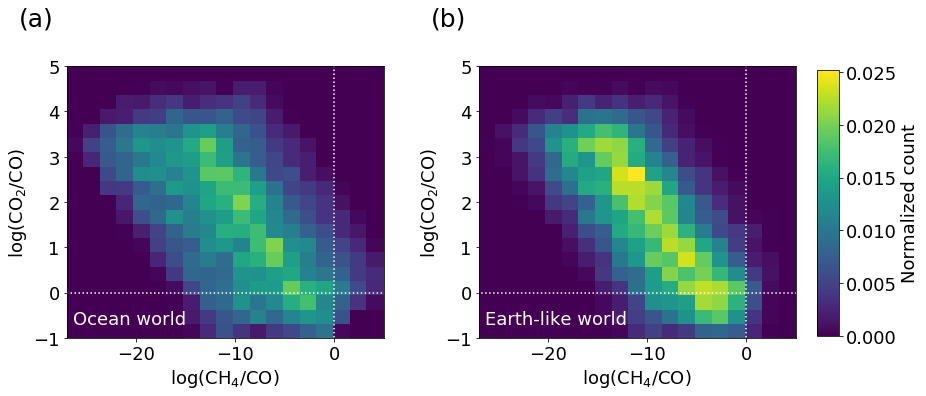

In [7]:
plt.rcParams.update({'font.size': 18})


fig,[ax,ax1] = plt.subplots(1,2,figsize=[15,5])
results = resultsb
# xbins = np.linspace(np.log10(min(results[:,1])), np.log10(max(results[:,1])), 20)
# ybins = np.linspace(np.log10(min(results[:,0])), np.log10(max(results[:,0])), 20)
xbins = np.linspace(-27,5, 20)
ybins = np.linspace(-1, 5, 20)

counts1, _, _ = np.histogram2d(np.log10(results[:,1]), np.log10(results[:,0]), bins=(xbins, ybins),normed=True)
cs1 = ax1.pcolormesh(xbins, ybins, counts1.T,vmin=0, vmax=np.max(counts1))
#ax1.set_ylabel(r"$\log(\mathrm{CO}/\mathrm{CO_2})$")
#ax1.set_xlabel(r"$\log(\mathrm{CO}/\mathrm{CH_4})$")
ax1.set_ylabel(r"$\log(\mathrm{CO_2}/\mathrm{CO})$")
ax1.set_xlabel(r"$\log(\mathrm{CH_4}/\mathrm{CO})$")
#ax1.set_xticks(np.arange(0,22,5))
#cbar1 = plt.colorbar(cs1,ax=ax1)
#cbar1.set_label("Probability density")


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.13, 0.02, 0.74])
cbar = fig.colorbar(cs1, cax=cbar_ax)

results = resultso
# xbins = np.linspace(np.log10(min(results[:,1])), np.log10(max(results[:,1])), 20)
# ybins = np.linspace(np.log10(min(results[:,0])), np.log10(max(results[:,0])), 20)
xbins = np.linspace(-27,5, 20)
ybins = np.linspace(-1, 5, 20)
#counts, _, _ = np.histogram2d(np.log10(results[:,1]), np.log10(results[:,0]), bins=(xbins, ybins),normed=True)
#cs = ax.pcolormesh(xbins, ybins, counts.T,vmin=0, vmax=np.max(counts1))
ax.hist2d(np.log10(results[:,1]), np.log10(results[:,0]),bins=(xbins, ybins),normed=True,vmax=np.max(counts1))
#ax.set_ylabel(r"$\log(\mathrm{CO}/\mathrm{CO_2})$")
#ax.set_xlabel(r"$\log(\mathrm{CO}/\mathrm{CH_4})$")
ax.set_ylabel(r"$\log(\mathrm{CO_2}/\mathrm{CO})$")
ax.set_xlabel(r"$\log(\mathrm{CH_4}/\mathrm{CO})$")
#cbar = plt.colorbar(cs,ax=ax)
cbar.set_label("Normalized count")
#ax.set_xticks(np.arange(0,22,5))
plt.subplots_adjust(wspace=.3)

ax.text(-0.15, 1.15, '(a)', transform=ax.transAxes,size=25)
ax1.text(-0.15, 1.15, '(b)', transform=ax1.transAxes,size=25)

ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])
ax1.set_ylim(ax1.get_ylim()[0],ax1.get_ylim()[1])
ax1.set_xlim(ax1.get_xlim()[0],ax1.get_xlim()[1])
ax.text(0.02, 0.05, 'Ocean world', transform=ax.transAxes,color='w')
ax1.text(0.02, 0.05, 'Earth-like world', transform=ax1.transAxes,color='w')
xxx = np.linspace(-40,10)
ax.plot(xxx,xxx*0,'w:')
ax.plot(xxx*0,xxx,'w:')

ax1.plot(xxx,xxx*0,'w:')
ax1.plot(xxx*0,xxx,'w:')

num_nan = np.sum(np.isnan(resultso[:,1]))
print('fraction of Ocean world calculations where CH4/CO2>1 = ',\
      len(np.where(resultso[:,1][~np.isnan(resultso[:,1])]>1)[0])/(n-num_nan))

num_nan = np.sum(np.isnan(resultsb[:,1]))
print('fraction of Earth-like world calculations where CH4/CO2>1 = ',\
      len(np.where(resultsb[:,1][~np.isnan(resultsb[:,1])]>1)[0])/(n-num_nan))


# ax.set_xlim(-27,5)
# ax.set_ylim(-1,5)

# plt.savefig("both.pdf",bbox_inches='tight')

plt.show()

Fraction ocean world calulations where CH4 > 10 Tmol assuming
1 times Earths magma production rate = 0.0018000000000000238

Fraction Earth-like world calulations where CH4 > 10 Tmol assuming
1 times Earths magma production rate = 0.0004999999999999449


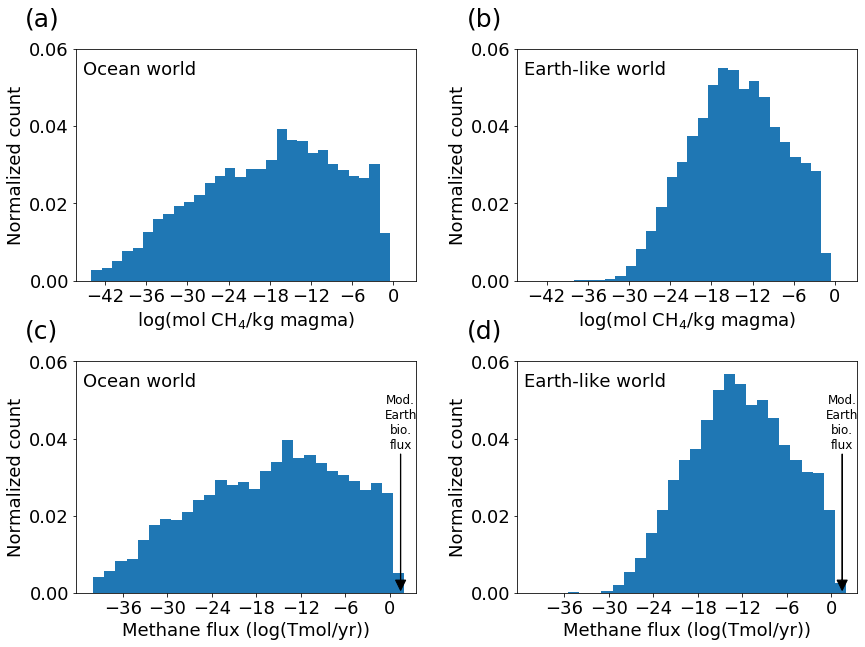

In [8]:
plt.rcParams.update({'font.size': 18})
mod_earth = 30*3000*1e9

fig,[[ax2,ax3],[ax4,ax5]] = plt.subplots(2,2,figsize=[14,10])#,gridspec_kw={'height_ratios':[3,2]})

#ax.set_xticks(np.arange(0,22,5))
plt.subplots_adjust(wspace=.3,hspace=.35)

# ax.text(-0.15, 1.10, '(a)', transform=ax.transAxes,size=25)
# ax1.text(-0.15, 1.10, '(b)', transform=ax1.transAxes,size=25)
ax2.text(-0.15, 1.10, '(a)', transform=ax2.transAxes,size=25)
ax3.text(-0.15, 1.10, '(b)', transform=ax3.transAxes,size=25)
ax4.text(-0.15, 1.10, '(c)', transform=ax4.transAxes,size=25)
ax5.text(-0.15, 1.10, '(d)', transform=ax5.transAxes,size=25)

# ax.text(0.02, 0.05, 'Ocean world', transform=ax.transAxes,color='w')
# ax1.text(0.02, 0.05, 'Earth-like world', transform=ax1.transAxes,color='w')
ax2.text(0.02, 0.89, 'Ocean world', transform=ax2.transAxes,color='k')
ax3.text(0.02, 0.89, 'Earth-like world', transform=ax3.transAxes,color='k')
ax4.text(0.02, 0.89, 'Ocean world', transform=ax4.transAxes,color='k')
ax5.text(0.02, 0.89, 'Earth-like world', transform=ax5.transAxes,color='k')

ax4.arrow


#plt.savefig("both.pdf",bbox_inches='tight')

# now other things

bins = np.arange(-44,2,1.5)
ax2.set_xticks(np.arange(-42,1,6))
ax3.set_xticks(np.arange(-42,1,6))
ax2.hist(np.log10(resultso[:,3]),bins = bins,normed=True)
ax2.set_ylabel('Normalized count')
ax2.set_xlabel('log(mol $\mathrm{CH_4}$/kg magma)')

ax3.hist(np.log10(resultsb[:,3]),bins = bins,normed=True)
ax3.set_ylabel('Normalized count')
ax3.set_xlabel('log(mol $\mathrm{CH_4}$/kg magma)')

ax2.set_xlim(ax2.get_xlim()[0],ax2.get_xlim()[1])
ax3.set_xlim(ax2.get_xlim()[0],ax2.get_xlim()[1])

ax2.set_ylim(ax3.get_ylim()[0],ax3.get_ylim()[1])
ax3.set_ylim(ax3.get_ylim()[0],ax3.get_ylim()[1])

ax2.set_yticks([0.,0.02,0.04,0.06])
ax3.set_yticks([0.,0.02,0.04,0.06])

# now gas fluxes
bins1 = np.arange(-40,8,1.5)
ax4.set_xticks(np.arange(-36,2,6))
ax5.set_xticks(np.arange(-36,2,6))
ax4.hist(np.log10(resultso[:,3]*mod_earth/1e12),bins = bins1,normed=True)

ax4.set_ylabel('Normalized count')
ax4.set_xlabel('Methane flux (log(Tmol/yr))')

ax5.hist(np.log10(resultsb[:,3]*mod_earth/1e12),bins = bins1,normed=True)

ax5.set_ylabel('Normalized count')
ax5.set_xlabel('Methane flux (log(Tmol/yr))')

ax4.set_xlim(ax4.get_xlim()[0],3.5)

ax4.set_xlim(ax4.get_xlim()[0],ax4.get_xlim()[1])
ax5.set_xlim(ax4.get_xlim()[0],ax4.get_xlim()[1])

ax4.set_ylim(ax5.get_ylim()[0],ax5.get_ylim()[1])
ax5.set_ylim(ax5.get_ylim()[0],ax5.get_ylim()[1])

ax4.set_yticks([0.,0.02,0.04,0.06])
ax5.set_yticks([0.,0.02,0.04,0.06])


Ebio = 30
lims = ax4.get_xlim()
val = ((lims[1]-lims[0])-(lims[1]-np.log10(Ebio)))/(lims[1]-lims[0])
ax4.text(val,.61,'Mod.\nEarth\nbio.\nflux',ha='center',va='bottom', transform=ax4.transAxes,fontsize = 12)
ax4.arrow(val, .6, 0, -0.59, transform=ax4.transAxes, length_includes_head=True\
               ,head_width = .03,fc='k')

lims = ax5.get_xlim()
val = ((lims[1]-lims[0])-(lims[1]-np.log10(Ebio)))/(lims[1]-lims[0])
ax5.text(val,.61,'Mod.\nEarth\nbio.\nflux',ha='center',va='bottom', transform=ax5.transAxes,fontsize = 12)
ax5.arrow(val, .6, 0, -0.59, transform=ax5.transAxes, length_includes_head=True\
               ,head_width = .03,fc='k')



volc_flux = 1
num_nan = np.count_nonzero(np.isnan(resultso[:,3]))
print('Fraction ocean world calulations where CH4 > 10 Tmol assuming\n'+str(volc_flux)+\
      ' times Earths magma production rate =',1-(len(np.where(resultso[:,3]*volc_flux*mod_earth/1e12 < 10)[0])+num_nan)/n)
print()
num_nan = np.count_nonzero(np.isnan(resultsb[:,3]))
print('Fraction Earth-like world calulations where CH4 > 10 Tmol assuming\n'+str(volc_flux)+\
      ' times Earths magma production rate =',1-(len(np.where(resultsb[:,3]*volc_flux*mod_earth/1e12 < 10)[0])+num_nan)/n)

# plt.savefig("CH4_prod.pdf",bbox_inches='tight')
plt.show()